In [382]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [383]:
import numpy as np
from matplotlib.pyplot import *
import npp

In [384]:
import matplotlib
matplotlib.rc('image', cmap='gray_r')
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

rtitle = lambda t: matplotlib.pyplot.title(t, y=1.2)
def matshow_symm(data, *args, **kwargs):
    maxabs = np.abs(data[~np.isnan(data)]).max()
    matshow(data, *args, vmin=-maxabs, vmax=maxabs, **kwargs)

In [385]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create fake dataset with specific variance properties

In [386]:
def make_params():
    # partitions are always listed in the order (A, B, C, AB, AC, BC, ABC)
    part_names = ('a', 'b', 'c', 'ab', 'ac', 'bc', 'abc')
    model_names = ('A', 'B', 'C', 'AB', 'AC', 'BC', 'ABC')

    # which partitions are combined to get each full feature space?
    combs = [[0, 3, 4, 6],
             [1, 3, 5, 6],
             [2, 4, 5, 6]]

    # total_variance is total fraction of non-noise variance in responses
    total_variance = 0.05

    # true_variances is proportion of variance assigned to each partition
    #true_variances = np.ones(7) # each partition is equal
    #true_variances = np.array([1088, 662, 9501, 251, 284, 1872, 555]).astype(float) # values from speech experiment
    #true_variances = np.array([1088, 0, 0, 251, 284, 1872, 555]).astype(float) # values from speech experiment
    true_variances = np.array([1, 1, 1, 1, 1, 1, 1])
    true_variances = true_variances / float(true_variances.sum()) * total_variance

    noise_variance = 1.0 - true_variances.sum()

    # P_parts is number of components that together describe the variance in each partition
    #P_parts = [1] * 7 # 1 component in each partition
    #P_parts = [10] * 7 # 10 component in each partition
    #P_parts = [10, 10, 900, 10, 10, 10, 10]
    P_parts = [1, 1, 1, 1, 1, 1, 1]

    # P_models contains size of each feature space (each must be bigger than sum of constituent parts)
    #P_models = [300, 22, 985] # like speech experiment
    #P_models = [1200, 88, 3940] # REALLY like speech experiment
    #P_models = [9, 5, 19] # like Mark's experiment
    #P_models = [50, 50, 50]
    #P_models = [10, 10, 10]
    P_models = [50, 10, 300]

    # Pnoise_models is number of noise features in each feature space
    Pnoise_models = [P - np.array(P_parts)[c].sum() for P,c in zip(P_models, combs)]

    # N_R is number of training (regression) timepoints, N_P is number of validation (prediction) timepoints
    N_R, N_P = 3737, 300 # like speech experiment
    #N_R, N_P = 1260, 126 # like Mark's experiment

    # M is number of voxels to simulate
    M = 500

    data_params = locals()
    return data_params

data_params = make_params()

In [387]:
from varpart import make_data, compare

# Create dataset
data = make_data(use_mixing=False, orthogonalize=True, noise_scale=0.1, **data_params)

X_parts[0].shape (1, 4037)
Btrue_parts[0].shape (1, 500)
Y_parts[0].shape (4037, 500)
scaled_Y_parts[0].shape (4037, 500)
scaled_Y_noise.shape (4037, 500)
Y_total.shape (4037, 500)
Xtrue_feats[0].shape (4, 4037)
Xnoise_feats[0].shape (46, 4037)
mixing_mats[0].shape (50, 50)
X_feats[0].shape (50, 4037)
bulked_X_feats[0].shape (300, 4037)


## Compare correlation ($r^2$) vs. coefficient of determination ($R^2$)

corr MSE: Orig: 0.000132, Fixed: 0.000050, Ratio: fixed 2.658x better
Rsq MSE:  Orig: 0.000384, Fixed: 0.000039, Ratio: fixed 9.950x better

corr vs. Rsq fixed MSE: corr 0.776x better

corr Variance: Orig: 0.000084, Fixed: 0.000035, Ratio: fixed 2.415x better
Rsq Variance: Orig: 0.000122, Fixed: 0.000011, Ratio: fixed 11.165x better

corr vs. Rsq fixed variance: corr 0.312x better

corr Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.20596230e-02  -4.26930503e-03
  -1.00617752e-02  -2.87394773e-03   7.57145673e-03], 
Fixed: [  4.59800314e-05   4.11099489e-03  -4.45263412e-03  -1.22188199e-03
  -6.42975672e-03  -4.46185473e-03  -2.12888158e-03], 
Ratio: fixed 1.716x better

Rsq Bias: 
Orig: [-0.00693937 -0.00692395 -0.03842088 -0.01065519 -0.00276186  0.00606748
  0.01027402], 
Fixed: [ -3.56609126e-03   8.98496282e-05  -7.11294332e-03  -3.83354407e-03
  -7.03115496e-03  -6.97422987e-03  -4.21125359e-03], 
Ratio: fixed 2.500x better

corr vs. Rsq fixed bias: corr 1.436x better


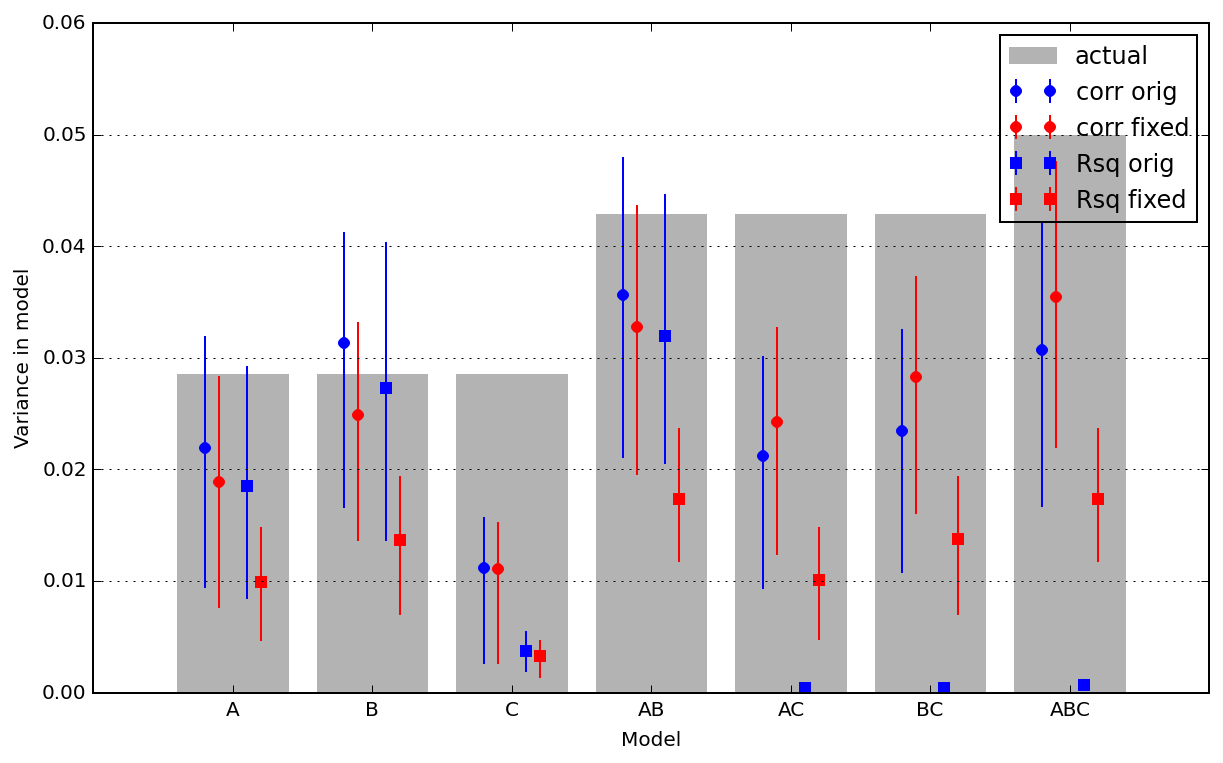

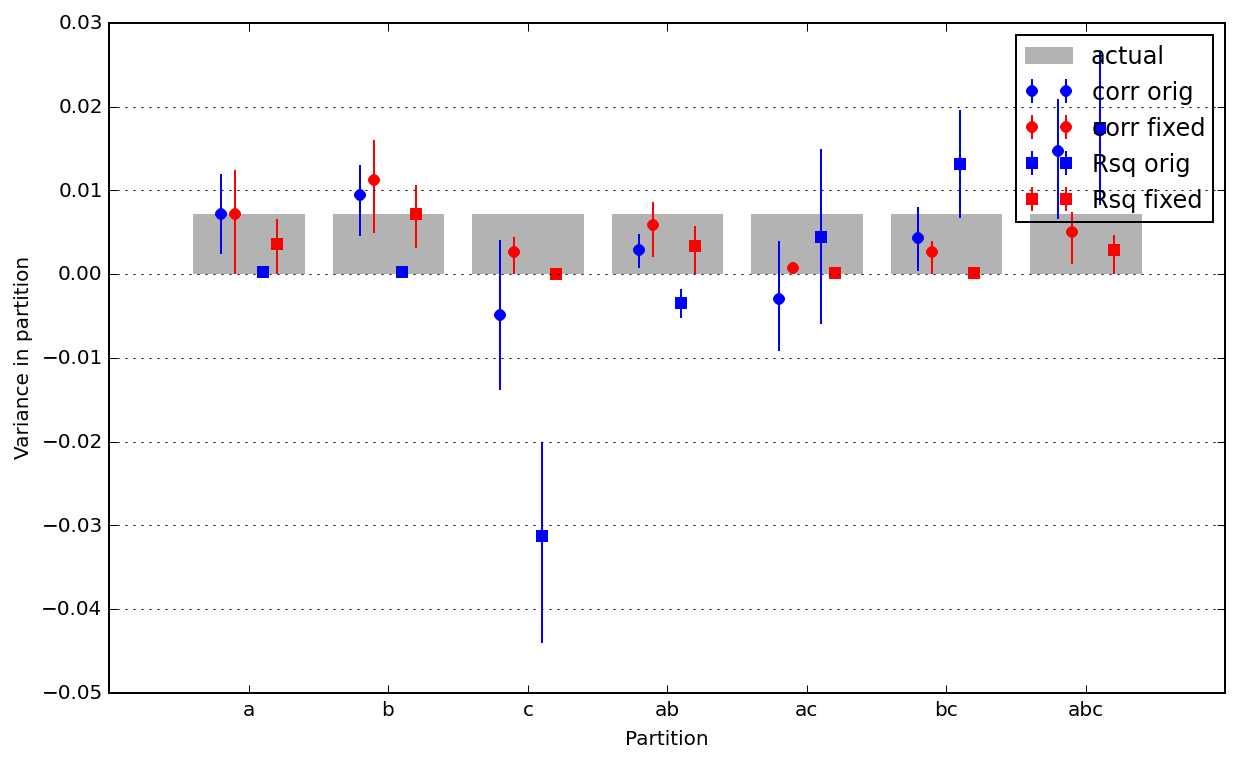

In [388]:
compare(dict(metric="corr"), dict(metric="rsq"), "corr", "Rsq", 
        data_params, data, verbose=False, nboots=10)

## Compare ridge regression vs. ordinary least squares (OLS)

ridge MSE: Orig: 0.000119, Fixed: 0.000049, Ratio: fixed 2.437x better
ols MSE:  Orig: 0.000208, Fixed: 0.000049, Ratio: fixed 4.217x better

ridge vs. ols fixed MSE: ridge 1.009x better

ridge Variance: Orig: 0.000071, Fixed: 0.000034, Ratio: fixed 2.088x better
ols Variance: Orig: 0.000117, Fixed: 0.000033, Ratio: fixed 3.532x better

ridge vs. ols fixed variance: ridge 0.983x better

ridge Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.19224234e-02  -4.26930503e-03
  -1.02052359e-02  -3.01114730e-03   7.71491734e-03], 
Fixed: [ -5.65157377e-05   4.04966238e-03  -4.32686625e-03  -1.13450182e-03
  -6.60942897e-03  -4.59421173e-03  -1.93356757e-03], 
Ratio: fixed 1.740x better

ols Bias: 
Orig: [-0.00521448 -0.00294641 -0.02140037 -0.00402971 -0.00639225  0.00076654
  0.00895285], 
Fixed: [-0.00233116  0.00156539 -0.00577904 -0.00160878 -0.0064211  -0.00502895
 -0.00125605], 
Ratio: fixed 2.072x better

ridge vs. ols fixed bias: ridge 1.057x better


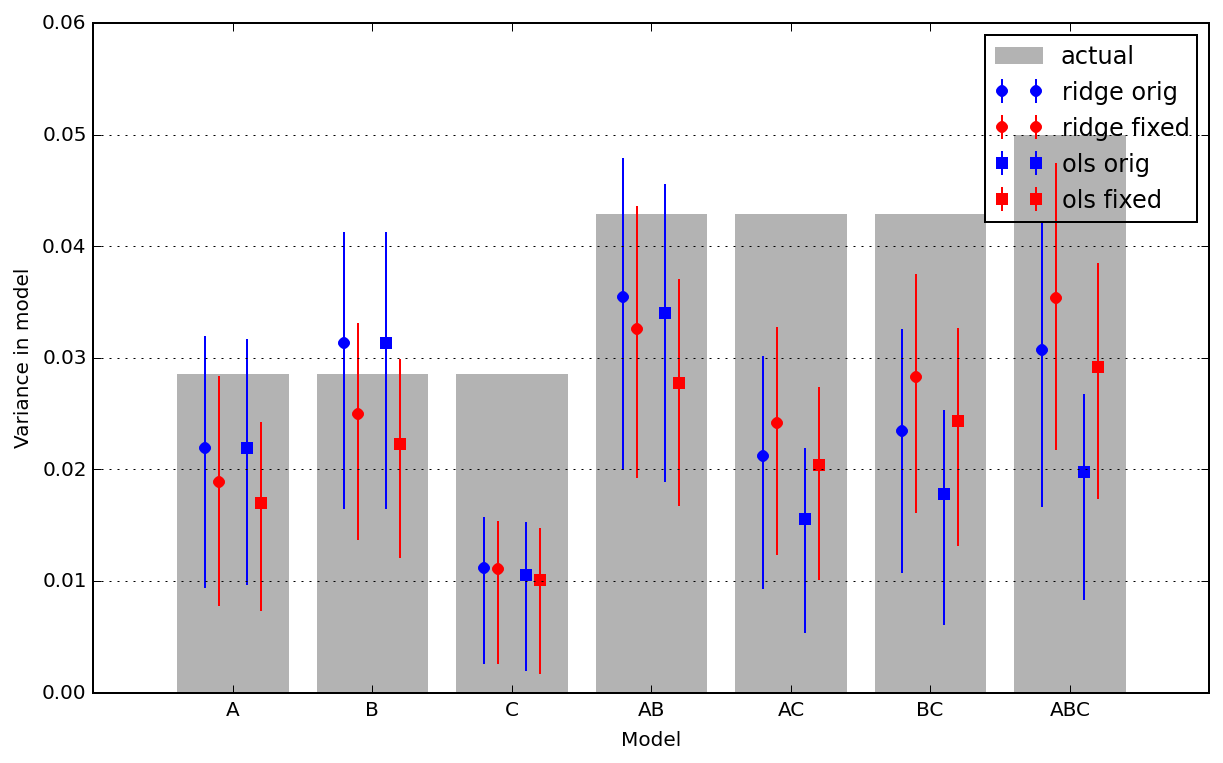

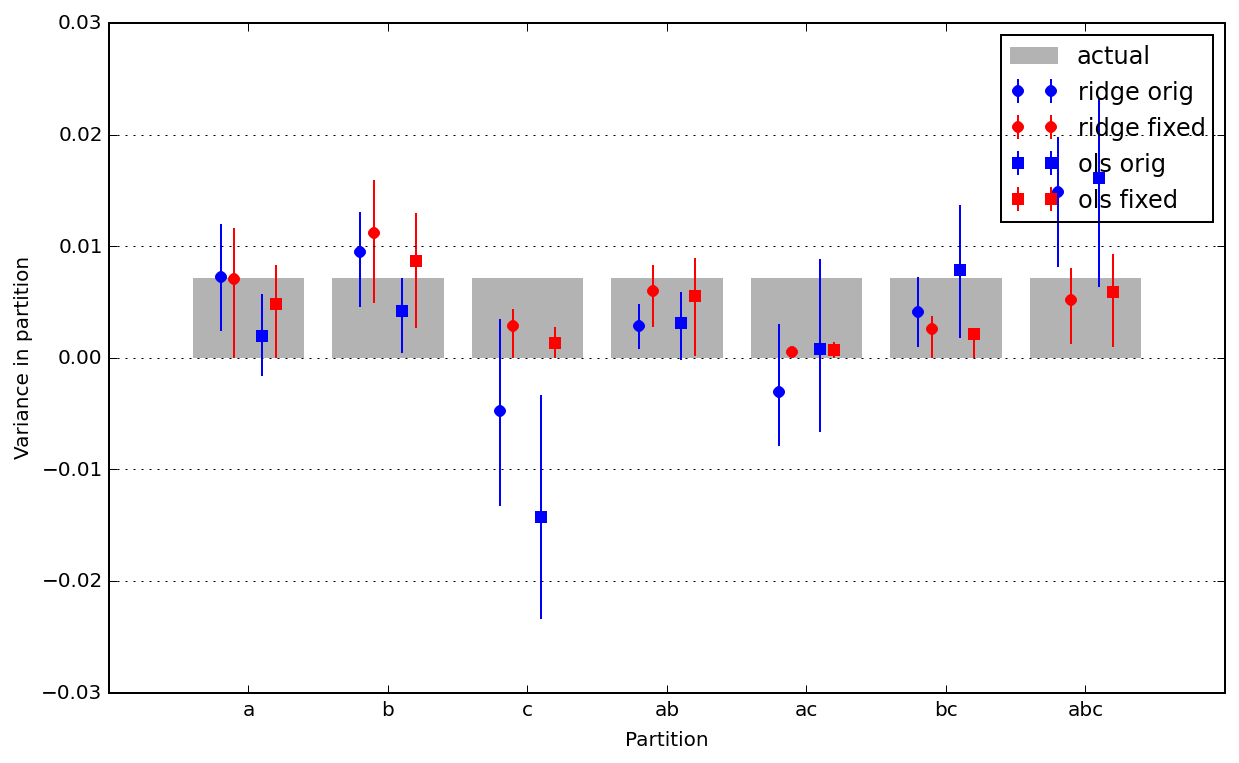

In [389]:
compare(dict(use_ols=False), dict(use_ols=True), "ridge", "ols", 
        data_params, data, verbose=False, nboots=10)

## Compare correction with unconstrained bias vs. negative-only bias

uncons-bias MSE: Orig: 0.000119, Fixed: 0.000049, Ratio: fixed 2.437x better
negonly-bias MSE:  Orig: 0.000119, Fixed: 0.000079, Ratio: fixed 1.505x better

uncons-bias vs. negonly-bias fixed MSE: uncons-bias 1.619x better

uncons-bias Variance: Orig: 0.000071, Fixed: 0.000034, Ratio: fixed 2.088x better
negonly-bias Variance: Orig: 0.000071, Fixed: 0.000058, Ratio: fixed 1.211x better

uncons-bias vs. negonly-bias fixed variance: uncons-bias 1.725x better

uncons-bias Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.19224234e-02  -4.26930503e-03
  -1.02052359e-02  -3.01114730e-03   7.71491734e-03], 
Fixed: [ -5.65157377e-05   4.04966238e-03  -4.32686625e-03  -1.13450182e-03
  -6.60942897e-03  -4.59421173e-03  -1.93356757e-03], 
Ratio: fixed 1.740x better

negonly-bias Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.19224234e-02  -4.26930503e-03
  -1.02052359e-02  -3.01114730e-03   7.71491734e-03], 
Fixed: [ 0.0002859   0.00747945 -0.00443715  0.00161245 -0.0065841  -0.00440845


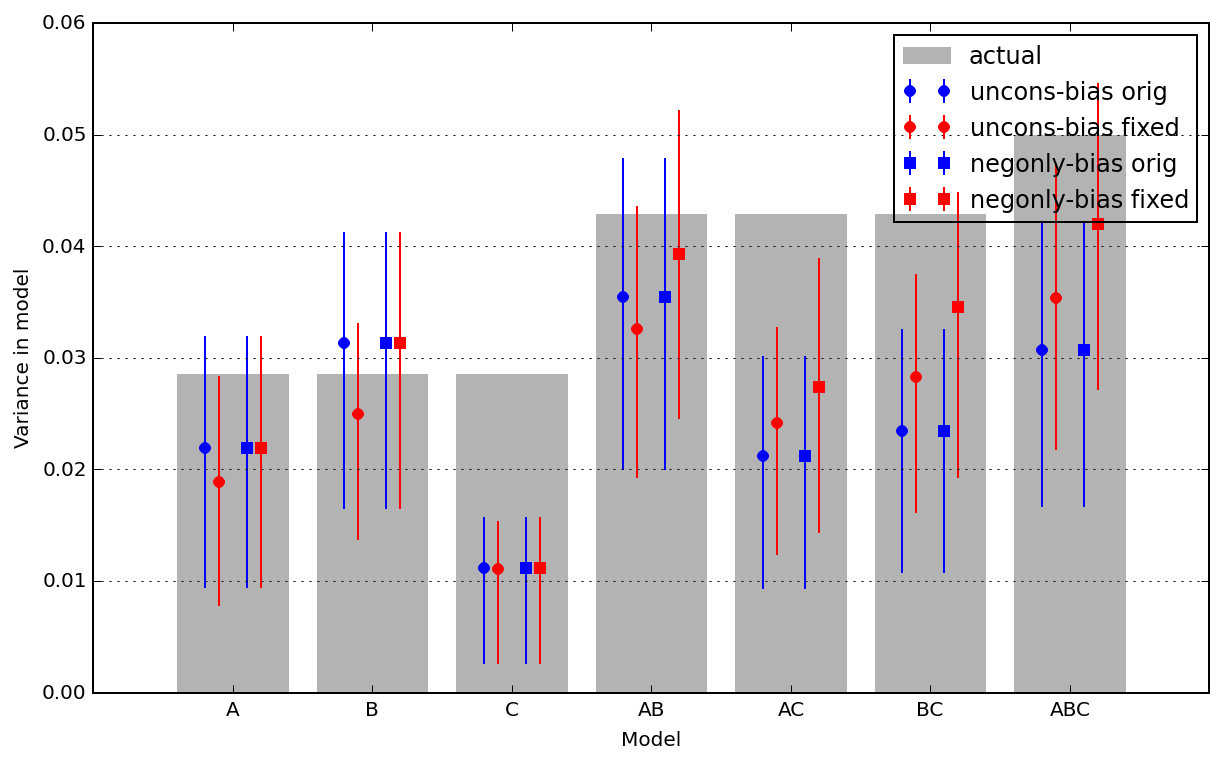

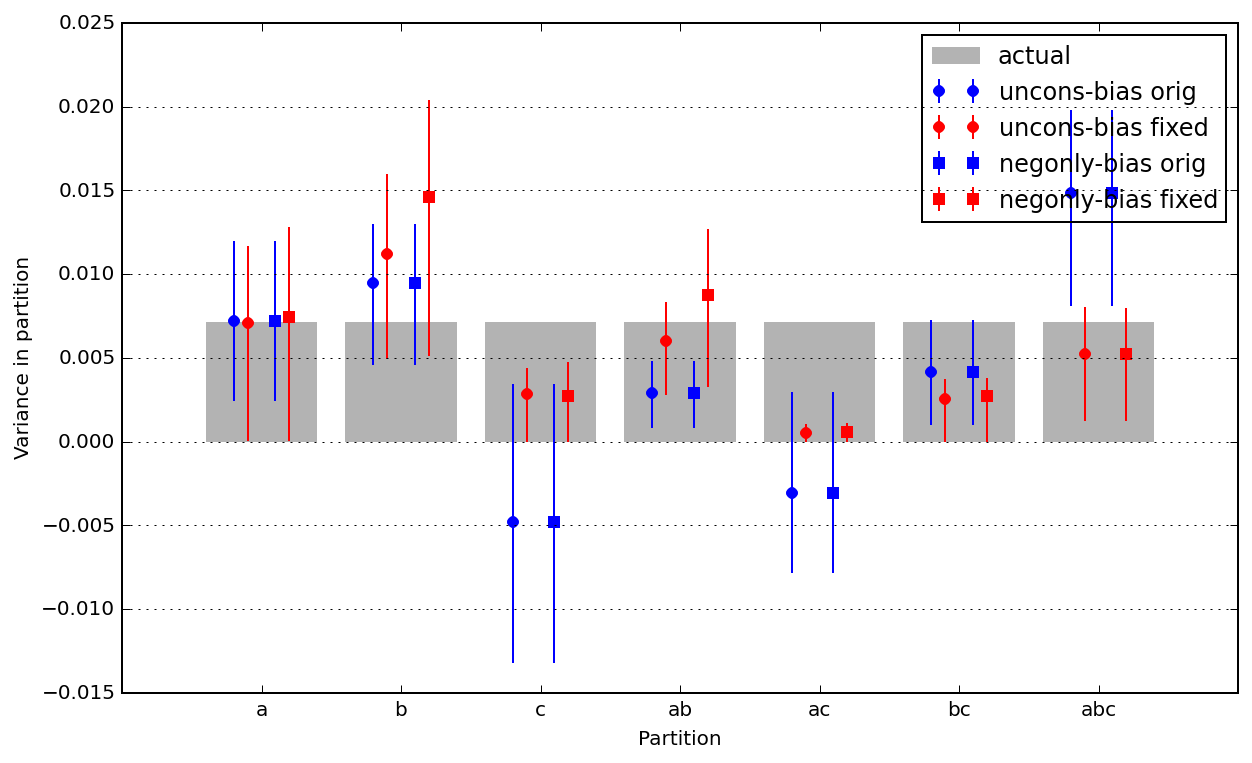

In [390]:
compare(dict(neg_only=False), dict(neg_only=True), "uncons-bias", "negonly-bias", 
        data_params, data, verbose=False)

## Compare bulked features vs. raw features

bulked MSE: Orig: 0.000058, Fixed: 0.000048, Ratio: fixed 1.218x better
raw MSE:  Orig: 0.000133, Fixed: 0.000050, Ratio: fixed 2.642x better

bulked vs. raw fixed MSE: bulked 1.054x better

bulked Variance: Orig: 0.000038, Fixed: 0.000027, Ratio: fixed 1.427x better
raw Variance: Orig: 0.000086, Fixed: 0.000035, Ratio: fixed 2.425x better

bulked vs. raw fixed variance: bulked 1.318x better

bulked Bias: 
Orig: [-0.00333379 -0.00272585 -0.00254136 -0.00598548 -0.00594005 -0.00568953
 -0.00325295], 
Fixed: [-0.001496   -0.00098281 -0.00091819 -0.00602356 -0.00605834 -0.0058898
 -0.00587406], 
Ratio: fixed 1.082x better

raw Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.20596230e-02  -4.01393494e-03
  -1.00680363e-02  -2.87394773e-03   7.32234768e-03], 
Fixed: [  3.27566472e-05   4.10031100e-03  -4.44120280e-03  -9.24016110e-04
  -6.43691536e-03  -4.47720272e-03  -2.39126611e-03], 
Ratio: fixed 1.698x better

bulked vs. raw fixed bias: bulked 0.837x better


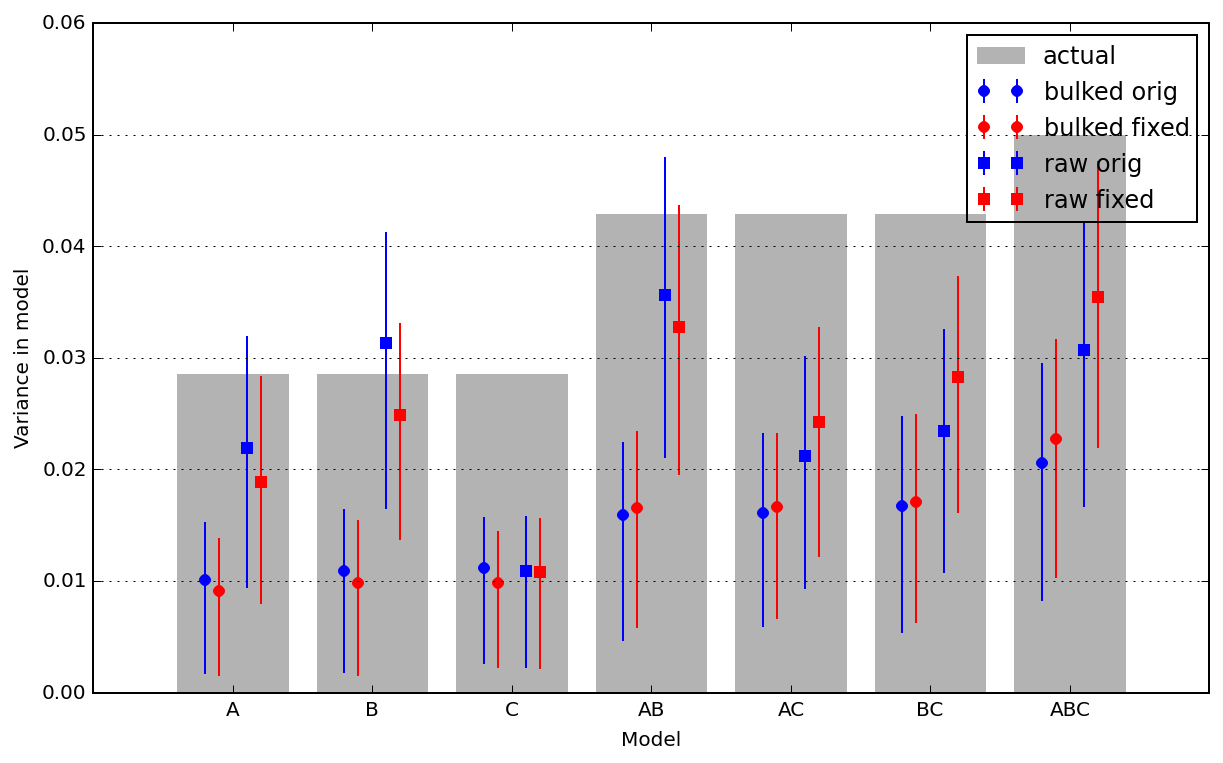

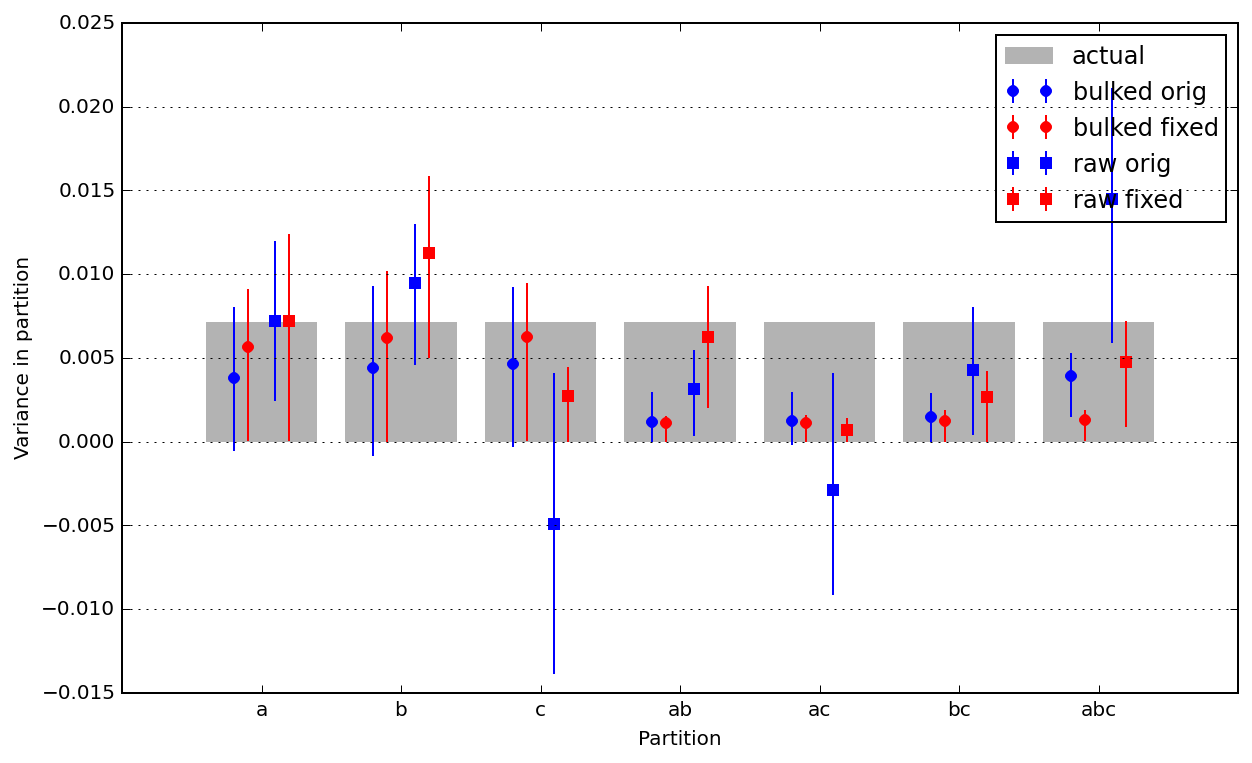

In [391]:
compare(dict(use_features="bulked"), dict(use_features="raw"), "bulked", "raw", 
        data_params, data, verbose=False)

## Compare same-size models vs. raw features

same MSE: Orig: 0.000202, Fixed: 0.000060, Ratio: fixed 3.386x better
raw MSE:  Orig: 0.000119, Fixed: 0.000049, Ratio: fixed 2.438x better

same vs. raw fixed MSE: same 0.819x better

same Variance: Orig: 0.000172, Fixed: 0.000038, Ratio: fixed 4.546x better
raw Variance: Orig: 0.000071, Fixed: 0.000034, Ratio: fixed 2.089x better

same vs. raw fixed variance: same 0.892x better

same Bias: 
Orig: [ 0.00189871  0.0025039   0.00264617 -0.00535205 -0.00564304 -0.00544222
 -0.00991922], 
Fixed: [ 0.00055604  0.0010336   0.00232928 -0.00542048 -0.00593127 -0.0058617
 -0.00677266], 
Ratio: fixed 1.197x better

raw Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.19224234e-02  -4.26930503e-03
  -1.02052864e-02  -3.01114730e-03   7.71496784e-03], 
Fixed: [ -5.66758619e-05   4.04972972e-03  -4.32671457e-03  -1.13434169e-03
  -6.60919910e-03  -4.59436341e-03  -1.93379745e-03], 
Ratio: fixed 1.740x better

same vs. raw fixed bias: same 0.814x better


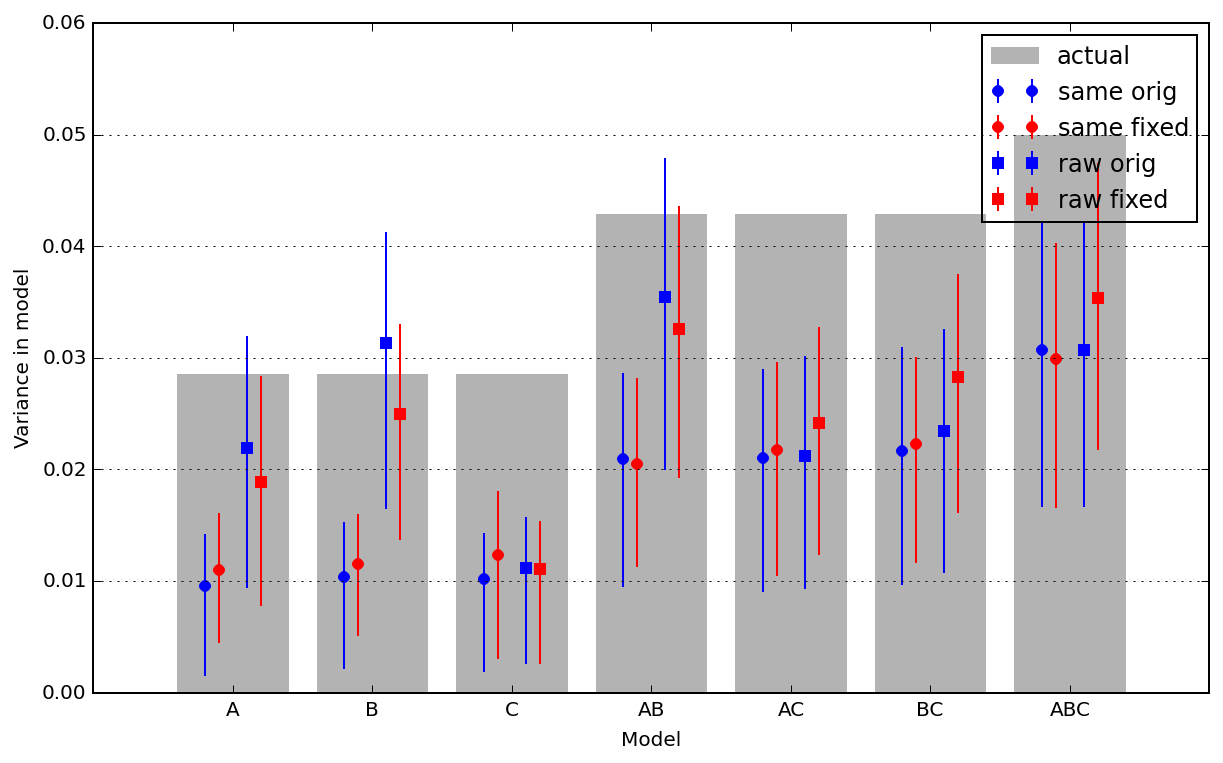

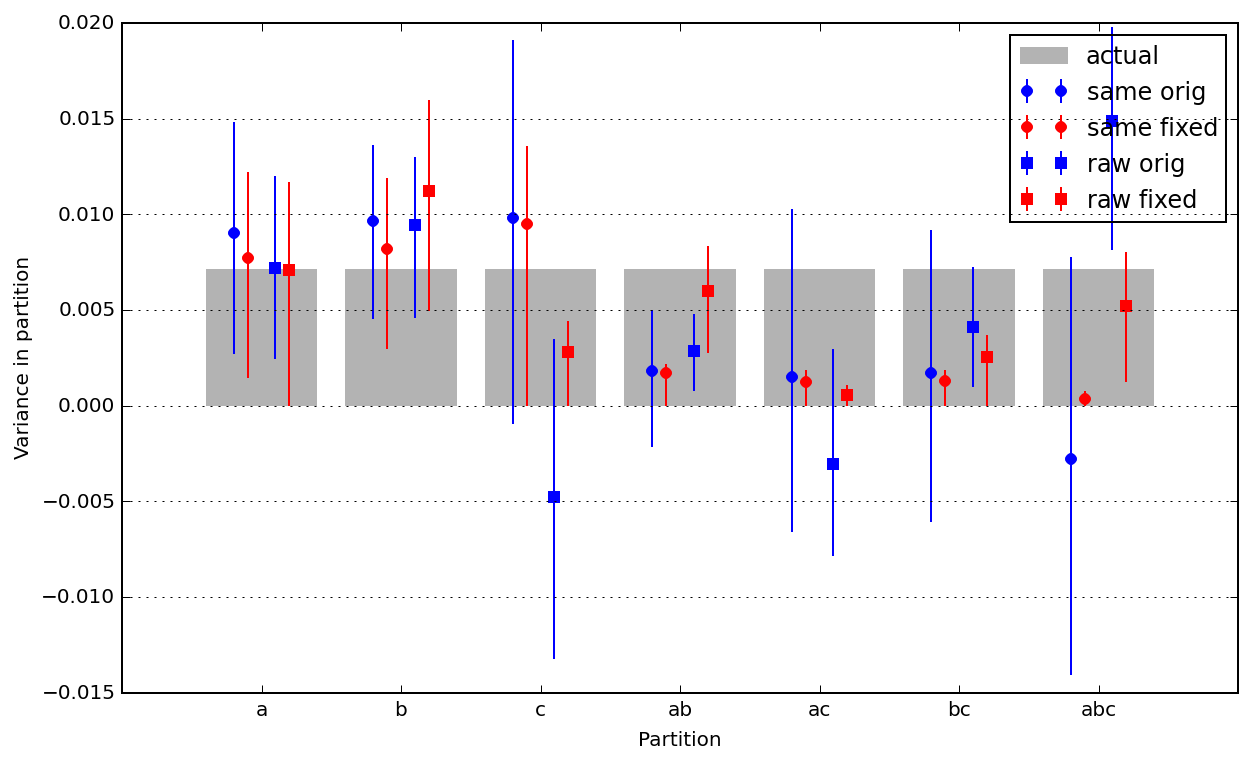

In [392]:
compare(dict(use_features="same"), dict(use_features="raw"), "same", "raw", 
        data_params, data, verbose=False)

## Compare L2 vs. L1 bias minimization in correction

min-L2-bias MSE: Orig: 0.000133, Fixed: 0.000050, Ratio: fixed 2.642x better
min-L1-bias MSE:  Orig: 0.000119, Fixed: 0.000087, Ratio: fixed 1.375x better

min-L2-bias vs. min-L1-bias fixed MSE: min-L2-bias 1.721x better

min-L2-bias Variance: Orig: 0.000086, Fixed: 0.000035, Ratio: fixed 2.425x better
min-L1-bias Variance: Orig: 0.000071, Fixed: 0.000065, Ratio: fixed 1.089x better

min-L2-bias vs. min-L1-bias fixed variance: min-L2-bias 1.835x better

min-L2-bias Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.20596230e-02  -4.01393494e-03
  -1.00680363e-02  -2.87394773e-03   7.32234768e-03], 
Fixed: [  3.27566472e-05   4.10031100e-03  -4.44120280e-03  -9.24016110e-04
  -6.43691536e-03  -4.47720272e-03  -2.39126611e-03], 
Ratio: fixed 1.698x better

min-L1-bias Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.19224234e-02  -4.26930503e-03
  -1.02052359e-02  -3.01114730e-03   7.71491734e-03], 
Fixed: [  4.76989235e-04   8.04533419e-03  -4.45177392e-03   7.11033803e-05
  -6.5942

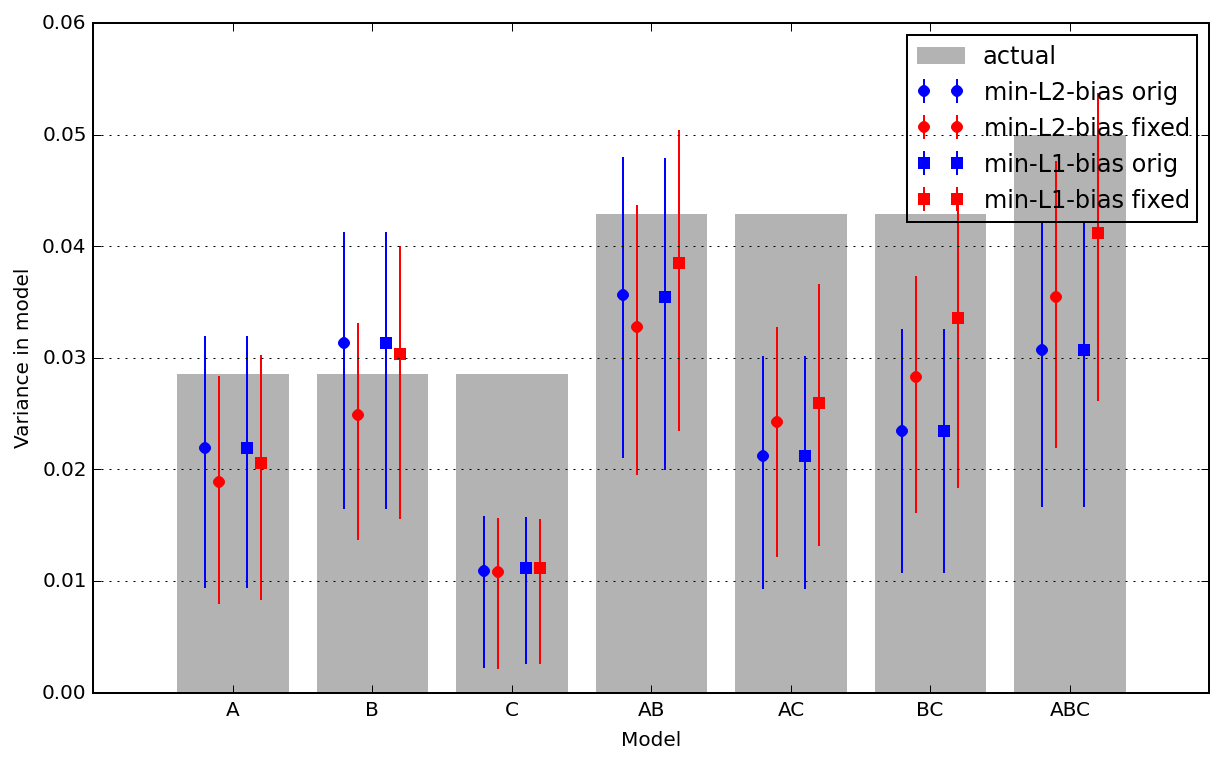

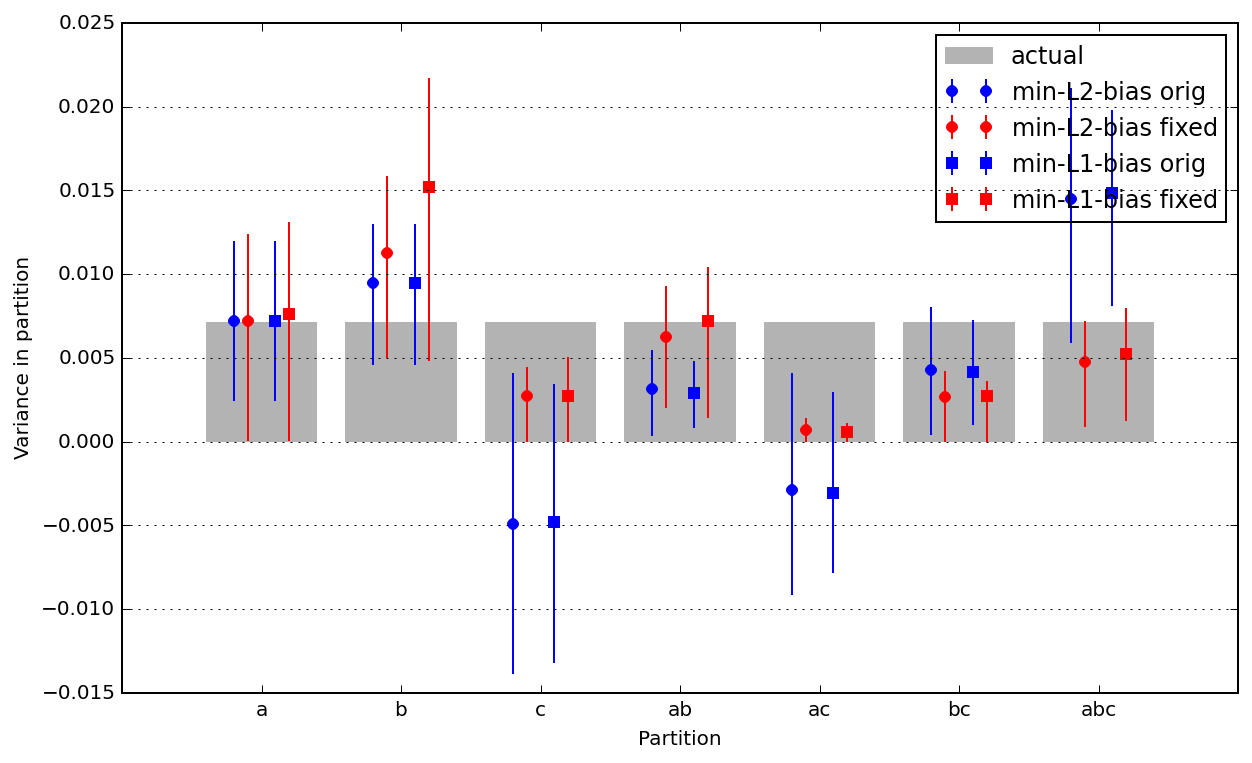

In [393]:
compare(dict(minimize="l2"), dict(minimize="l1"), "min-L2-bias", "min-L1-bias", 
        data_params, data, verbose=False)

## Compare ideal models vs. raw features

ideal MSE: Orig: 0.000186, Fixed: 0.000048, Ratio: fixed 3.919x better
raw MSE:  Orig: 0.000133, Fixed: 0.000050, Ratio: fixed 2.642x better

ideal vs. raw fixed MSE: ideal 1.058x better

ideal Variance: Orig: 0.000102, Fixed: 0.000033, Ratio: fixed 3.120x better
raw Variance: Orig: 0.000086, Fixed: 0.000035, Ratio: fixed 2.425x better

ideal vs. raw fixed variance: ideal 1.083x better

ideal Bias: 
Orig: [-0.00490585 -0.00320983 -0.02105005 -0.00365657 -0.00598351  0.00174667
  0.00786299], 
Fixed: [-0.00204621  0.00148446 -0.00565482 -0.00179866 -0.00631727 -0.00466926
 -0.00103296], 
Ratio: fixed 2.105x better

raw Bias: 
Orig: [  7.66829301e-05   2.30875002e-03  -1.20596230e-02  -4.01393494e-03
  -1.00680363e-02  -2.87394773e-03   7.32234768e-03], 
Fixed: [  3.27566472e-05   4.10031100e-03  -4.44120280e-03  -9.24016110e-04
  -6.43691536e-03  -4.47720272e-03  -2.39126611e-03], 
Ratio: fixed 1.698x better

ideal vs. raw fixed bias: ideal 0.991x better


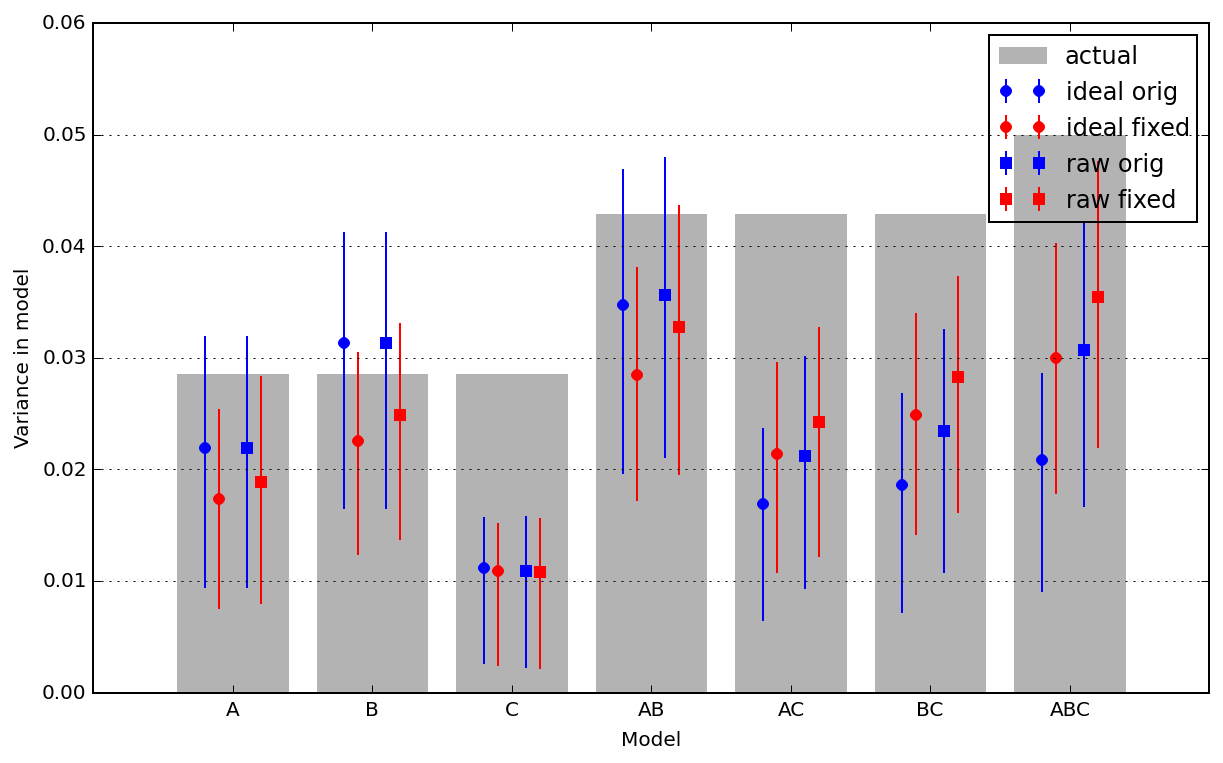

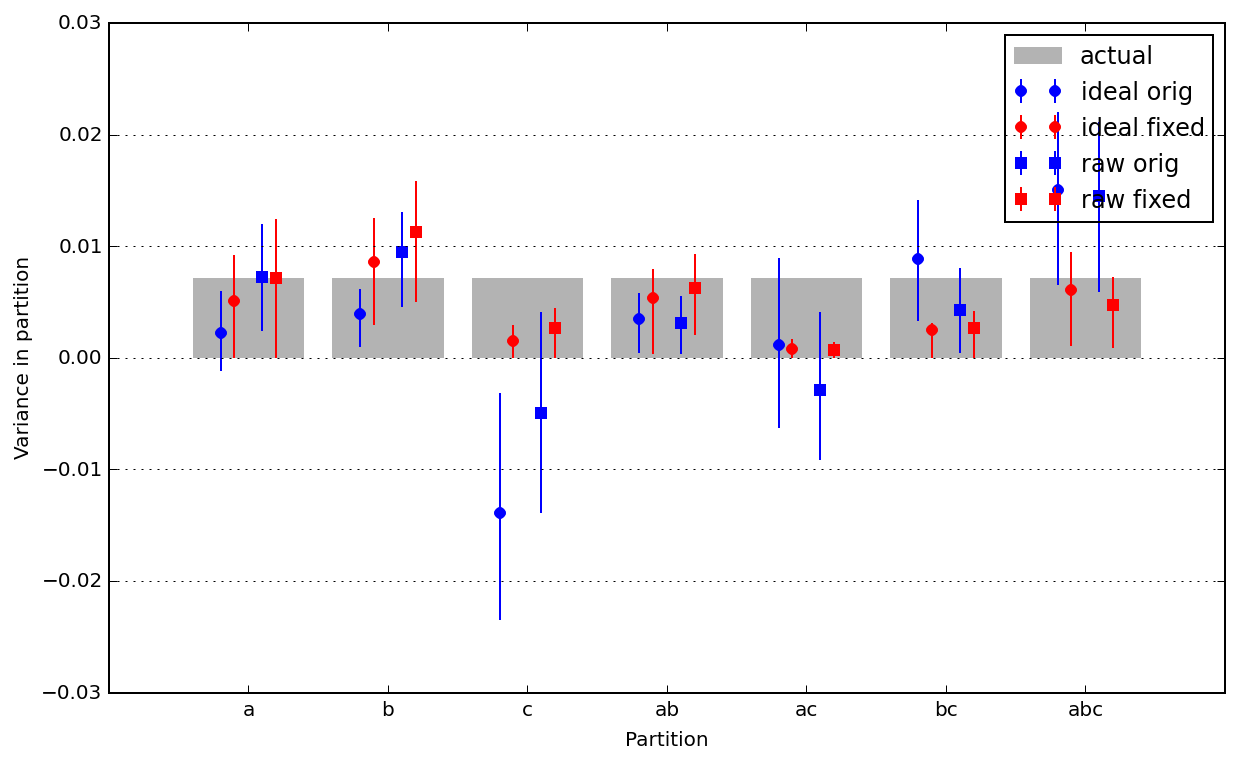

In [394]:
compare(dict(use_features="ideal"), dict(use_features="raw"), "ideal", "raw", 
        data_params, data, verbose=False)